## 3.2线性回归代码的实现
### 这里没用使用李沐老师的d2l这个库
线性回归最简单的理解就是拟合一个线性方程形如：
$$
y = Xw + b
$$

In [6]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import torch

### 这里参考李沐老师的数据集，使用线性模型参数w = [2,-3.4]、b=4.2以及一个噪声项这里记为a
### 3.2.1 生成数据集

In [4]:
def synthetic_data(w, b, num_examples):
    """生成y = W^T X  + b + a"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) # 高斯噪声项
    return X, y.view((-1, 1))
true_w = torch.Tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [5]:
# 查看一下features和labels
print('features:', features[0], '\nlabels:', labels[0])

features: tensor([ 1.2460, -0.3997]) 
labels: tensor([8.0433])


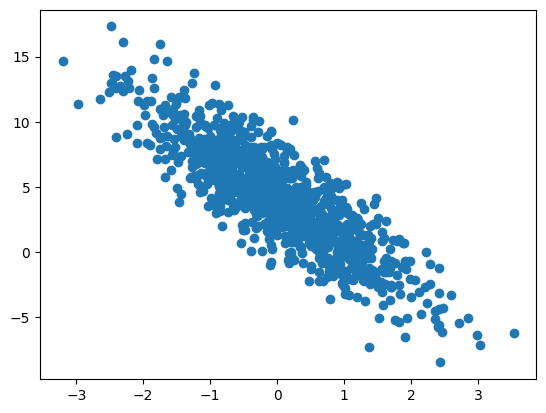

In [12]:
# 画一个散点图观察一下大体的关系，这里主要是第二个特征和labels的散点图，李沐老师的书中使用d2l，这里我没有选择使用
x_axis = features[:,1].numpy() # 拿到第二个特征的所有数据并且转换为numpy格式
y_axis = labels.numpy() # 将labels转换为numpy格式
plt.scatter(x_axis, y_axis)
plt.show()

### 3.2.2 读取数据集
定义一个数据读取的函数，该函数可以打乱数据集并且以小批量的方式获取数据

In [15]:
def data_iter(batch_size, features, labels):
    num_examples = len(features) # 总共有多少样本/数据
    indices = list(range(num_examples)) # 
    # 打乱顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i+batch_size, num_examples)]
        )
        yield features[batch_indices], labels[batch_indices] # yield用于定义生成器函数，可以理解为每一次迭代就会产生一组数据

In [14]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)

tensor([[ 2.0377, -0.2789],
        [ 0.7042, -1.6693],
        [ 1.2280, -0.3883],
        [-1.3244, -0.1056],
        [-0.7787, -0.7815],
        [ 0.1109, -0.6985],
        [ 0.0837,  1.2397],
        [-0.0768, -0.5824],
        [-0.3203,  0.2513],
        [-0.6900, -0.3047]]) 
 tensor([[ 9.2324],
        [11.2805],
        [ 7.9781],
        [ 1.9204],
        [ 5.2846],
        [ 6.7879],
        [ 0.1515],
        [ 6.0210],
        [ 2.7059],
        [ 3.8427]])
tensor([[ 1.2200,  0.1243],
        [ 0.0384, -1.3158],
        [ 0.2419,  1.0645],
        [-0.5087,  1.0153],
        [-0.2432,  0.5890],
        [-0.8172,  1.1004],
        [-0.0163,  0.1592],
        [ 1.4286,  1.8764],
        [-0.7975,  0.4888],
        [ 1.0819,  0.1820]]) 
 tensor([[ 6.2241],
        [ 8.7608],
        [ 1.0649],
        [-0.2786],
        [ 1.7168],
        [-1.1807],
        [ 3.6460],
        [ 0.6868],
        [ 0.9268],
        [ 5.7251]])
tensor([[-0.0342,  0.6423],
        [-0.8214,  0.385

### 3.2.3 初始化模型参数

In [18]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 3.2.4 定义模型，损失函数，优化算法

In [25]:
# 定义模型
def linear_regression(X, w, b):
    return torch.matmul(X, w) + b
# 定义损失函数--均方损失MSE
def squared_loss(y_hat, y):
    return (y_hat-y.view(y_hat.shape))**2 / 2 
# 定义优化算法
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 3.2.7训练

In [27]:
lr = 0.01
num_epochs = 3
net = linear_regression
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w,b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch{epoch+1}, loss{float(train_l.mean()):f}')

epoch1, loss0.005023
epoch2, loss0.000725
epoch3, loss0.000140


In [28]:
print(f'w的估计误差: {true_w - w.view(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0022, -0.0084], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0112], grad_fn=<RsubBackward1>)


## 3.3线性回归的简洁实现

In [1]:
import numpy as np
import torch
from torch.utils import data
# 仍然使用从零实现时的数据
def synthetic_data(w, b, num_examples):
    """生成y = W^T X  + b + a"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) # 高斯噪声项
    return X, y.view((-1, 1))
true_w = torch.Tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [2]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个Pytorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
batch_size = 10
data_iter = load_array((features, labels), batch_size)

### 定义模型 初始化模型参数 定义损失函数 定义优化算法

In [9]:
net = torch.nn.Sequential(torch.nn.Linear(2, 1)) # 直接调用了一个线性层来实现

In [6]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [7]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

### 进行训练

In [8]:
num_epochs = 3

for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    l = loss(net(features), labels)
    print(f'epoch:{epoch+1}, loss {l:f}')

epoch:1, loss 0.546867
epoch:2, loss 0.009246
epoch:3, loss 0.000254
